In [1]:
import numpy as np
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as cp
    xp = cp
else:
    xp = np

import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import display, clear_output
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import warnings
warnings.filterwarnings("ignore")

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
import misc_funs as misc

from importlib import reload
reload(cgi)

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

pixelscale_lamD = 0.2

iwa = 2.8
owa = 9.7

data_dir = cgi.data_dir

dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

<Quantity 2.9590498e-35 sr>

<Quantity [400.      , 400.030003, 400.060006, ..., 699.939994, 699.969997,
           700.      ] nm>

<Quantity [8.13231992e-32, 8.13300514e-32, 8.13369010e-32, ...,
           6.99472313e-32, 6.99430378e-32, 6.99388443e-32] J m2 / (nm5 s sr)>

Unit("J / (m2 nm s)")

Text(0, 0.5, '$W/m^2/sr/nm$')

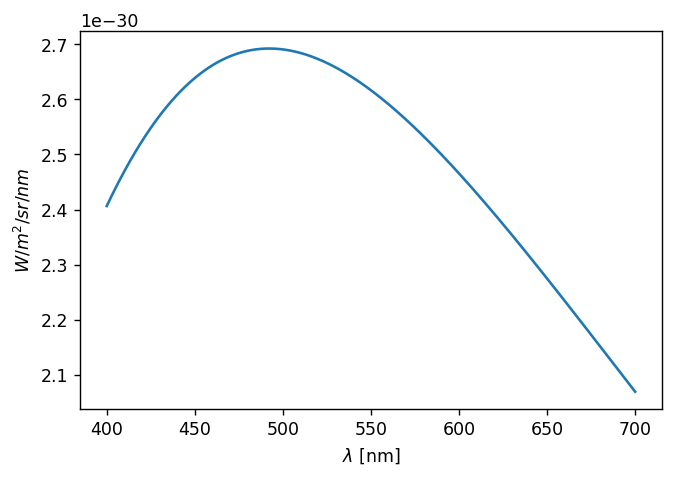

In [9]:
from astropy.constants import h, c, k_B

pupil_diam = 2.36*u.m
d = (14.06*u.parsec).to(u.m)
SA = (((pupil_diam/d)*u.radian)**2).to(u.sr)
display(SA)

T = 5887*u.K

lambdas = np.linspace(400, 700, 10000)*u.nm
display(lambdas)

spec = 2*np.pi*h*c**2/(lambdas**5)/(np.exp(h*c/(k_B*T*lambdas)) - 1)/u.sr
display(spec)

spec = spec.to(u.J/u.s/u.sr/u.m**2/u.nm) * SA
display(spec.unit)

fig,ax = plt.subplots(1,1,dpi=125)
ax.plot(lambdas, spec)
ax.set_xlabel('$\lambda$ [nm]')
ax.set_ylabel('$W/m^2/sr/nm$')

In [3]:
from scipy.integrate import simpson

fluxes = []

del_waves = wavelengths[1]-wavelengths[0]

for i in range(nlam):
    wave = wavelengths[i].to(u.nm)
    min_wave = wave-del_waves/2
    max_wave = wave+del_waves/2
    inds = np.where((lambdas>min_wave)&(lambdas<max_wave))
    
    wave_range = lambdas[inds].value
    spec_range = spec[inds].value
    display(wave_range)
    
    fluxes.append(simpson(spec_range, wave_range)*u.J/u.s/u.m**2) # integrate over the wave band
    
    E = h*c/wave.to(u.m) / u.photon # energy of the photon for this wavelength
    print(E)
    fluxes[i] /= E # convert to photons/s/m**2
    
print(fluxes)

array([531.89318932, 531.92319232, 531.95319532, 531.98319832,
       532.01320132, 532.04320432, 532.07320732, 532.10321032,
       532.13321332, 532.16321632, 532.19321932, 532.22322232,
       532.25322532, 532.28322832, 532.31323132, 532.34323432,
       532.37323732, 532.40324032, 532.43324332, 532.46324632,
       532.49324932, 532.52325233, 532.55325533, 532.58325833,
       532.61326133, 532.64326433, 532.67326733, 532.70327033,
       532.73327333, 532.76327633, 532.79327933, 532.82328233,
       532.85328533, 532.88328833, 532.91329133, 532.94329433,
       532.97329733, 533.00330033, 533.03330333, 533.06330633,
       533.09330933, 533.12331233, 533.15331533, 533.18331833,
       533.21332133, 533.24332433, 533.27332733, 533.30333033,
       533.33333333, 533.36333633, 533.39333933, 533.42334233,
       533.45334533, 533.48334833, 533.51335134, 533.54335434,
       533.57335734, 533.60336034, 533.63336334, 533.66336634,
       533.69336934, 533.72337234, 533.75337534, 533.78

3.636514154963714e-19 J / ph


array([560.63606361, 560.66606661, 560.69606961, 560.72607261,
       560.75607561, 560.78607861, 560.81608161, 560.84608461,
       560.87608761, 560.90609061, 560.93609361, 560.96609661,
       560.99609961, 561.02610261, 561.05610561, 561.08610861,
       561.11611161, 561.14611461, 561.17611761, 561.20612061,
       561.23612361, 561.26612661, 561.29612961, 561.32613261,
       561.35613561, 561.38613861, 561.41614161, 561.44614461,
       561.47614761, 561.50615062, 561.53615362, 561.56615662,
       561.59615962, 561.62616262, 561.65616562, 561.68616862,
       561.71617162, 561.74617462, 561.77617762, 561.80618062,
       561.83618362, 561.86618662, 561.89618962, 561.92619262,
       561.95619562, 561.98619862, 562.01620162, 562.04620462,
       562.07620762, 562.10621062, 562.13621362, 562.16621662,
       562.19621962, 562.22622262, 562.25622562, 562.28622862,
       562.31623162, 562.34623462, 562.37623762, 562.40624062,
       562.43624362, 562.46624662, 562.49624962, 562.52

3.454688447215529e-19 J / ph


array([589.37893789, 589.40894089, 589.43894389, 589.46894689,
       589.49894989, 589.5289529 , 589.5589559 , 589.5889589 ,
       589.6189619 , 589.6489649 , 589.6789679 , 589.7089709 ,
       589.7389739 , 589.7689769 , 589.7989799 , 589.8289829 ,
       589.8589859 , 589.8889889 , 589.9189919 , 589.9489949 ,
       589.9789979 , 590.0090009 , 590.0390039 , 590.0690069 ,
       590.0990099 , 590.1290129 , 590.1590159 , 590.1890189 ,
       590.2190219 , 590.2490249 , 590.2790279 , 590.3090309 ,
       590.3390339 , 590.3690369 , 590.3990399 , 590.4290429 ,
       590.4590459 , 590.4890489 , 590.51905191, 590.54905491,
       590.57905791, 590.60906091, 590.63906391, 590.66906691,
       590.69906991, 590.72907291, 590.75907591, 590.78907891,
       590.81908191, 590.84908491, 590.87908791, 590.90909091,
       590.93909391, 590.96909691, 590.99909991, 591.02910291,
       591.05910591, 591.08910891, 591.11911191, 591.14911491,
       591.17911791, 591.20912091, 591.23912391, 591.26

3.290179473538598e-19 J / ph
[<Quantity 2.07193615e-10 ph / (m2 s)>, <Quantity 2.11707251e-10 ph / (m2 s)>, <Quantity 2.14181692e-10 ph / (m2 s)>]


1.2302169081045814e-14 ph / s


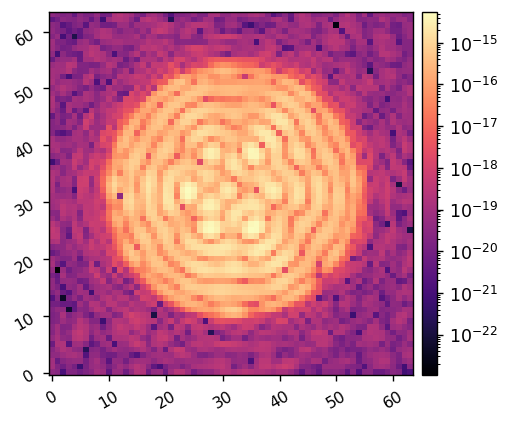

In [4]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=fluxes[1])

hlc.set_dm1(dm1_flat)
hlc.set_dm2(dm2_flat)

im = hlc.snap()
misc.imshow1(im, lognorm=True)

In [5]:
reload(cgi)
rayCGI = ray.remote(cgi.CGI)

mode_settings = {'cgi_mode':'hlc',
                 'use_pupil_defocus':True, 
                 'use_opds':True,}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_gpus=1/nlam).remote(wavelength=wavelengths[i], source_flux=fluxes[i], **mode_settings))


In [7]:
def snap_broadband_im(actors, QE=None, plot=False):
    pending_ims = []
    for i in range(len(actors)):
        actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
        actors[i].set_dm2.remote(dm2_flat)
        
        future_ims = actors[i].snap.remote()
        pending_ims.append(future_ims)
    ims = xp.array(ray.get(pending_ims))
    
    im = xp.sum(ims, axis=0)/len(actors) # average each of the 
    
    clear_output(wait=True)
    if plot:
        for i in range(len(actors)):
            misc.imshow1(ims[i], lognorm=True,)
#         misc.imshow1(im, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)
    
    return im

In [ ]:
T_bandpass = np.array([])
qe = np.array([])

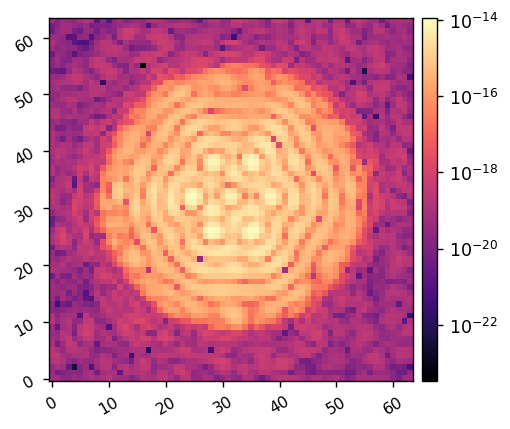

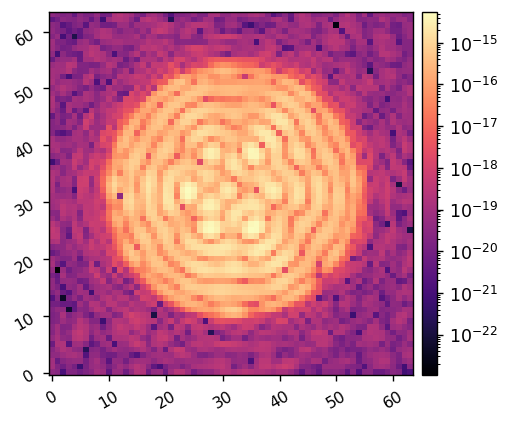

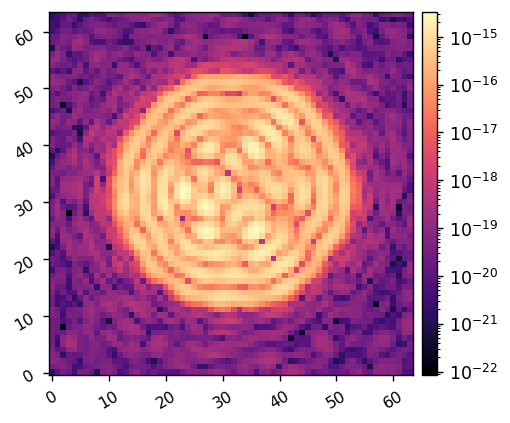

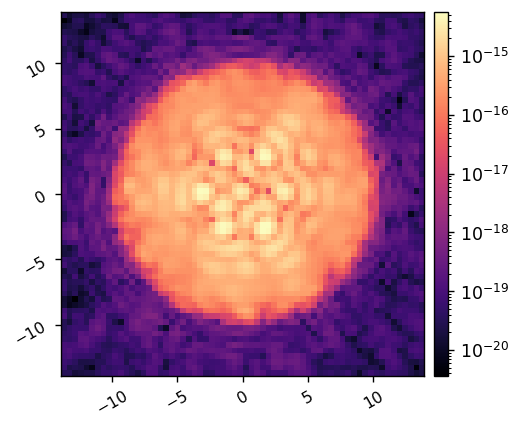

In [8]:
im = snap_broadband_im(actors, plot=True)
misc.imshow1(im, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)
